## **Quantum Billiards: a tight-binding approach**

In [1]:
import kwant
import kwant.continuum

import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

# enable latex
mpl.rcParams['text.usetex'] = True

from ipywidgets import interact

In [2]:
def make_billiard():

    a = 1/np.sqrt(2) # 1/sqrt(2) reads a unitary hopping energy
    #a = 0.25

    syst = kwant.Builder()
    lat = kwant.lattice.square(a)

    t = 1/(2 * a**2)
    print('hopping energy: ',t)

    def stadium(position):
        x, y, = position
        x = max(np.abs(x) - 20,0)
        return (x)**2 + (y)**2 < 20**2

    #onsite potential for the scattering region
    syst[lat.shape(stadium, (0,0))] = 4 * t
    
    # hopping in the scattering region, extremely dumb
    syst[lat.neighbors()] = -1 * t

    # taking care of the leads
    lead_symmetry = kwant.TranslationalSymmetry([-a,0])
    
    for start, end in [(-5,5)]: # lead goes from y = -5 to y = 5 at extreme left
        lead = kwant.Builder(lead_symmetry)
        lead[(lat(0,y) for y in range(start, end))] = 4 * t 
        lead[kwant.builder.HoppingKind((1,0), lat, lat)] = - 1 * t 
        lead[kwant.builder.HoppingKind((0,1), lat, lat)] = - 1 * t
        syst.attach_lead(lead)
        syst.attach_lead(lead.reversed()) #it's easy to attach the second lead this way
    
    kwant.plot(syst, fig_size=(10,10))

    syst = syst.finalized()

    # i wanto to show the Hamiltonian matrix
    ham_mat = syst.hamiltonian_submatrix()
    plt.matshow(ham_mat==0, cmap="gray", interpolation=None)


    return syst

def bands(syst, lead_number: int):
    
    # compute the band structure in the lead specified by lead_number
    bands = kwant.plotter.bands(syst.leads[lead_number], show=False)
    
    #fig_bands, ax_bands = plt.subplots(1,1, figsize=(8,4))
    #ax_bands.plot(bands)
    plt.xlabel('k',fontsize=20)
    plt.ylabel('E',fontsize=20)
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(linestyle='--')
    plt.show()

def conductance_energy_billiard(system, energies):

    data_conductance = []

    for energy in energies:
        # call the solver to compute the scattering matrix
        smatrix = kwant.smatrix(system, energy)
        # compute the transmission probability from lead 0 to lead 1
        trasmit = smatrix.transmission(1,0)
        data_conductance.append(trasmit)

    fig_cond, ax_cond = plt.subplots(1,1, figsize=(15,4))
    ax_cond.plot(energies, data_conductance)
    ax_cond.set_xlabel(r'$\mathrm{Energy}$ [$t$]',fontsize=20)
    ax_cond.set_ylabel(r'$G$ [$e^2/h$]',fontsize=20)
    ax_cond.tick_params(axis='both', labelsize=15)
    ax_cond.grid(linestyle='--')


def dos_billiard(system,energy):

    local_dos = kwant.ldos(system, energy)
    kwant.plotter.map(system, local_dos, num_lead_cells=10, cmap='inferno',fig_size=(12,4))

def closed_billiard(system):

    # extract the hamiltonian matrix
    ham_mat = system.hamiltonian_submatrix()

    eval, evec = la.eigh(ham_mat)

    #kwant.plotter.map(system, abs(evec[:,0])**2); 

    def plot_wf(i=0):
        print("Plotting wave function with index", i)
        print("energy:", eval[i],"x t") 
        kwant.plotter.map(system, abs(evec[:, i])**2,fig_size=(12,6))
    
    interact(plot_wf, i=(0, 45))


hopping energy:  1.0000000000000002


/tmp/ipykernel_9250/3293525579.py:34: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  kwant.plot(syst, fig_size=(10,10))


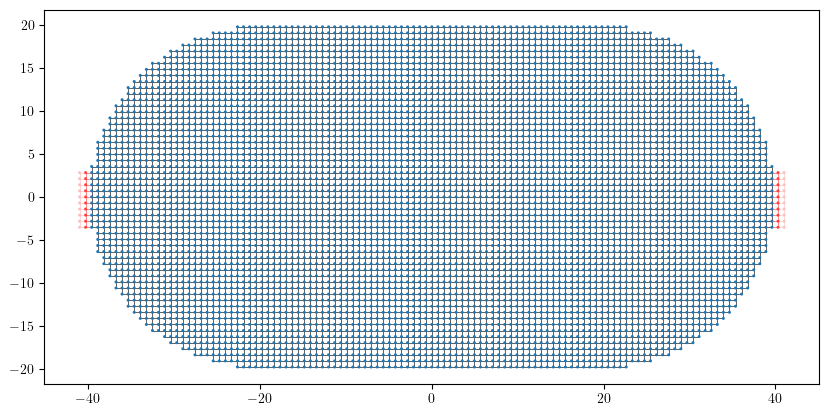

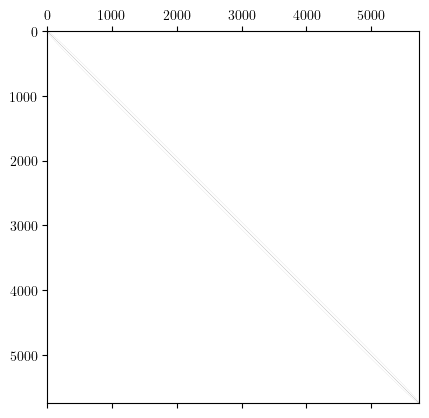

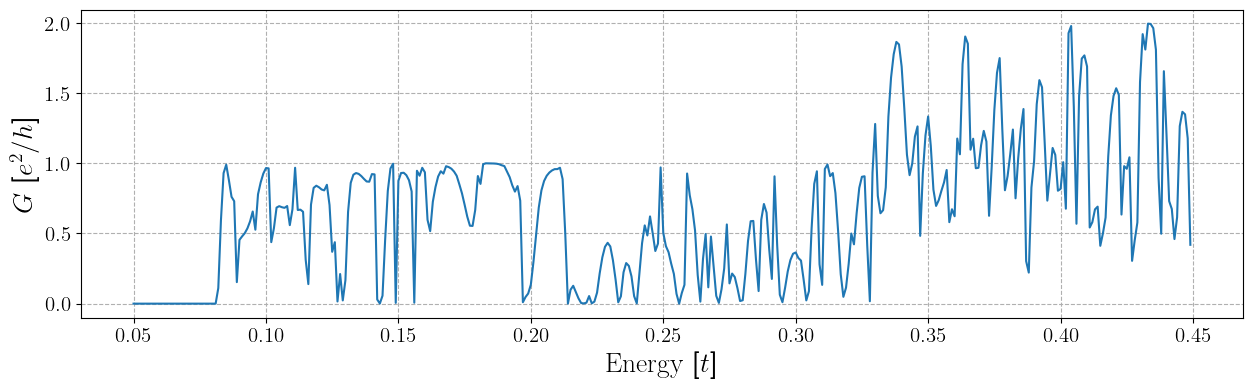

In [3]:
billiard = make_billiard()

energies = [0.05 + 1e-3*i for i in range(400)]

conductance_energy_billiard(billiard, energies)

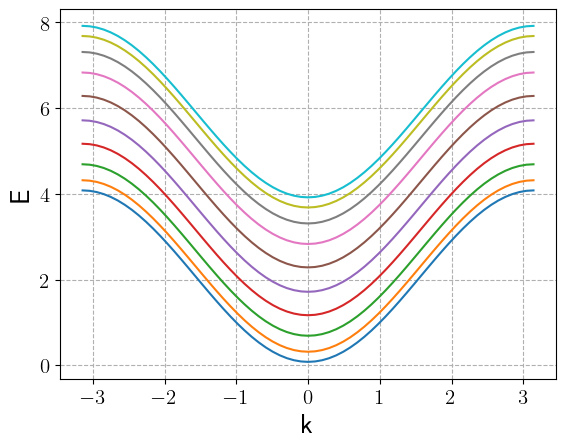

In [4]:
bands(billiard, 0)

/tmp/ipykernel_9250/3293525579.py:80: RuntimeWarning: The plotted data contains 1.00% of values overflowing upper limit 0.212454 
  kwant.plotter.map(system, local_dos, num_lead_cells=10, cmap='inferno',fig_size=(12,4))


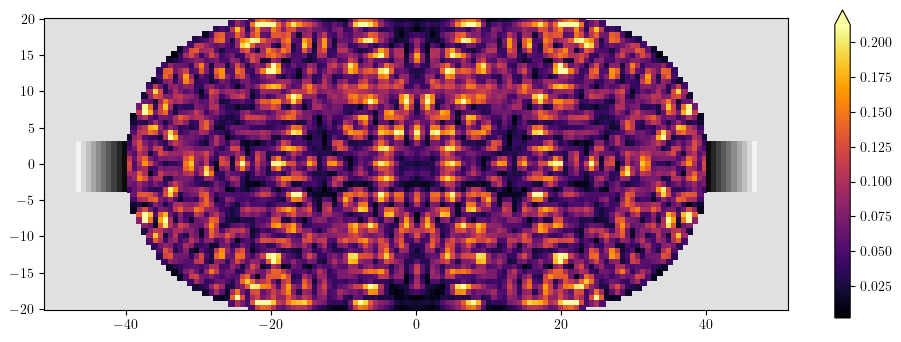

In [5]:
etry = 1.

dos_billiard(billiard, etry)

In [6]:
closed_billiard(billiard)

interactive(children=(IntSlider(value=0, description='i', max=45), Output()), _dom_classes=('widget-interact',…